100%|██████████| 578/578 [00:00<00:00, 1320.01it/s]


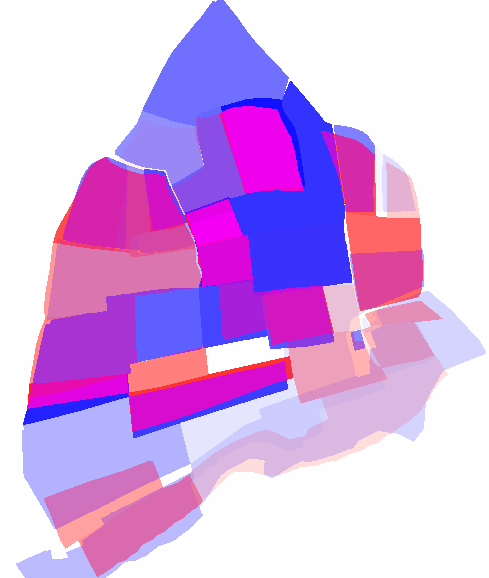

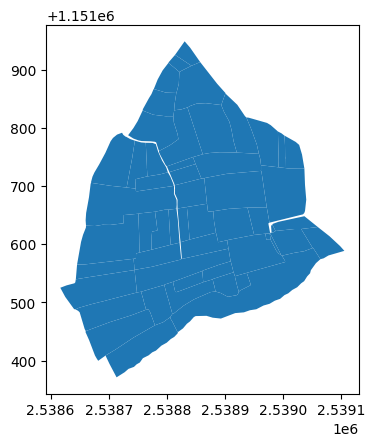

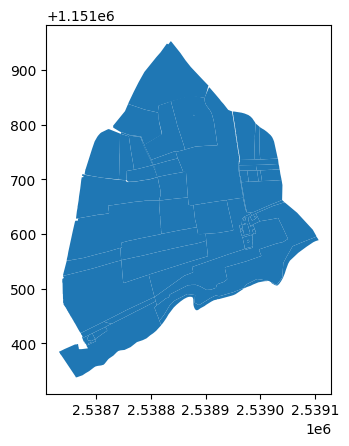

In [28]:
### Imports

import shapefile, tqdm, cv2, json
import numpy as np
import pandas as pd

from shapely.geometry import Polygon, MultiPolygon, Point
from shapely.geometry.base import BaseGeometry
from shapely.geometry.polygon import orient
from shapely.ops import unary_union

import geopandas as gpd

import rtree
from rtree import index
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split

from PIL import Image

import matplotlib.pyplot as plt
%matplotlib inline

import turning_function

### Functions

def create_index(gdf: gpd.GeoDataFrame):
    '''Creates an Index to accelerate data processing'''
    
    idx = index.Index()
    valid_geometries = list()
    
    for pos, geom in enumerate(gdf.geometry):
        
        # Skip null or empty geometries
        if geom is None:
            continue
        if geom.is_empty:
            continue
            
        # Validate and possibly fix geometry
        if not geom.is_valid:
            geom = geom.buffer(0)
            if not geom.is_valid or geom.is_empty:
                continue  # Skip still invalid or empty geometries after fixing
                
        valid_geometries.append(geom)
        
        # Ensure the bounds are in the correct format
        if len(geom.bounds) == 4:
            idx.insert(pos, geom.bounds)
        else:
            print(f"Skipped geometry at position {pos} with invalid bounds: {geom.bounds}")
            
    gdf.geometry = gpd.GeoSeries(valid_geometries)
    
    return idx, gdf

def match_parcels(gdf_1: gpd.GeoDataFrame, gdf_2: gpd.GeoDataFrame, index_1: rtree.Index, index_2: rtree.Index):
    '''Check which geometries are matching together and computes the relative overlap'''
    
    matches = dict()

    for i, poly1 in enumerate(tqdm.tqdm(gdf_1.geometry)):

        if poly1 is None:
            continue

        # Find potential matches based on bounding box overlap
        potential_indices = list(index_2.intersection(poly1.bounds))
        
        if len(potential_indices) > 0:
            
            # Focus on actual matches
            potential_matches = gdf_2.geometry.iloc[potential_indices]
            overlaps = potential_matches.intersects(poly1)
            actual_matches = np.array(potential_indices)[overlaps.values]
            
            # Computes the overlap
            actual_overlaps = gdf_2.geometry.iloc[actual_matches]
            overlap_ratio = actual_overlaps.intersection(poly1).area / poly1.area
            overlapping_matches = actual_matches[overlap_ratio > 0.5]

            if len(overlapping_matches) > 0:
                matches[i] = overlapping_matches.tolist()
                
    return matches

def reverse_matches(matches: dict):
    '''Get reciprocal matching relations'''
    
    rev_matches = dict()
    for key in matches.keys():
        matches_list = matches[key]
        for match in matches_list:
            if match in rev_matches.keys():
                rev_matches[match].append(key)
            else:
                rev_matches[match] = [key]
                
    return rev_matches

def create_polygons(parcel_list: list):
    '''Convert list of tuples to Shapely Polygon objects.'''
    polygons = list()
    for parcel in parcel_list:
        poly = Polygon(parcel)
        if not(poly.is_valid):
            poly = poly.buffer(0) # Adding a buffer of width 0 is a way of fixing invalid geometries
        if poly.area > 5:
            polygons.append(poly)
        
    return polygons

def overlap_percentage(old_poly: Polygon, new_poly: Polygon):
    '''Calculate the percentage of the old polygon's area covered by the new polygon'''
    try:
        intersection = old_poly.intersection(new_poly).area
        return (intersection / old_poly.area)
    except:
        return 0
    
def compare_polygons(poly_1: Polygon, poly_2: Polygon):
    ''' Return the Turning function score of two polygons'''
    
    def compute_signed_area(polygon):
        coords = list(polygon.exterior.coords)
        n = len(coords)
        signed_area = 0.0
        for i in range(n - 1):
            x0, y0 = coords[i]
            x1, y1 = coords[i + 1]
            signed_area += (x0 * y1 - x1 * y0)
        signed_area /= 2.0
        
        return signed_area

    def normalize_polygon(polygon):
        
        if compute_signed_area(polygon) < 0:        
            return orient(polygon, 1).normalize()
        else:
            return polygon.normalize()
    
    def list_points(polygon):
        x, y = normalize_polygon(polygon).exterior.coords.xy
        return [(x_, y_) for x_, y_ in zip(x, y)]
    
    dist, _, _, _ = turning_function.distance(list_points(poly_1), list_points(poly_2))
    
    return dist

def create_image(polygons: Polygon, bounds: tuple, grid_size: int = 2, max_score: float = 1.):
    '''Create an image from a list of polygons with associated Turning function scores.'''

    min_x, min_y, max_x, max_y = bounds
    
    # Initialize an empty canvas
    width = int((max_x - min_x + 1) / grid_size)
    height = int((max_y - min_y + 1) / grid_size)
    img = Image.new('L', (width, height))

    # Create an R-tree index for the polygons
    idx = index.Index()
    for i, poly in enumerate(polygons):
        idx.insert(i, poly['polygon'].bounds)

    # Go through each pixel in the image
    for x in tqdm.tqdm(range(width)):
        for y in range(height):
            # Create a point at the current pixel
            point = Point((x * grid_size) + min_x, (height - 1 - y) * grid_size + min_y)

            # Find the polygons that might contain this point
            for i in idx.intersection(point.coords[0]):
                poly = polygons[i]
                if poly['polygon'].contains(point):
                    
                    # Convert the Turning function score to a pixel intensity
                    score = min(max_score, poly['turning_score'])
                    intensity = int((1-score) * 255)

                    # Set the pixel's intensity
                    img.putpixel((x, y), intensity)
                    break

    return img

def compute_dynamics(rev_matches: dict, gdf_1: gpd.GeoDataFrame, gdf_2: gpd.GeoDataFrame):
    '''Compute fusion dynamics between gdf_1 and gdf_2'''
    
    dynamic = list()
    
    for key in tqdm.tqdm(rev_matches.keys()):
        poly_2 = gdf_2['geometry'][key]

        if len(rev_matches[key]) == 1:
            # one to one match
            poly_1 = gdf_1['geometry'][rev_matches[key][0]]
            match_type = 'one-to-one'

        else:
            # many to one
            poly_1 = unary_union(gdf_1['geometry'][rev_matches[key]])
            match_type = 'many-to-one'
            
        if not(poly_1.geom_type == 'Polygon'):
            poly_1 = convert_multipolygon_to_polygon(poly_1)
            if not (poly_1.geom_type == 'Polygon'):
                poly_1 = poly_1.geoms[np.argmax([geom.area for geom in poly_1.geoms])]
                
        if not(poly_2.geom_type == 'Polygon'):
            poly_2 = Polygon(convert_multipolygon_to_polygon(poly_2))
            if not (poly_2.geom_type == 'Polygon'):
                poly_2 = poly_2.geoms[np.argmax([geom.area for geom in poly_2.geoms])]
            
        dist = compare_polygons(poly_2, poly_1)

        dynamic.append({
            '1': rev_matches[key],
            '2': key,
            'match_type': match_type,
            'dist': dist,
        })
        
    return dynamic

def convert_multipolygon_to_polygon(multipolygon: MultiPolygon):
    '''Convert multipolygons to polygons by filling the gaps between parts'''

    # Ensure we're working with a MultiPolygon
    if not isinstance(multipolygon, MultiPolygon):
        raise TypeError("Input geometry must be a MultiPolygon")

    # Extract the individual polygons
    polygons = list(multipolygon.geoms)
    
    # Start with the first polygon
    polygon = polygons[0]

    # Iterate over the remaining polygons in the MultiPolygon
    for part in polygons[1:]:
        if part.area < 0.5:
            continue
        
        distance = polygon.distance(part)
        buffered_polygon = polygon.buffer(2 * distance)
        buffered_part = part.buffer(2 * distance)

        # Unary union of the buffered shapes
        combined = unary_union([buffered_polygon, buffered_part])

        # Apply negative buffer to shrink back
        polygon = combined.buffer(-2 * distance)
    
    return polygon

def compute_legend():
    '''Compute color red-pink-blue-white palette and legend for plotting'''

    size = 256
    legend = np.zeros((size, size, 3))

    colors = np.array([
        [1, 0, 0],  # Red
        [1, 0, 1],  # Pink
        [0, 0, 1],  # Blue
        [1, 1, 1],  # White
    ])

    for x in range(size):
        for y in range(size):
            # Calculate the weights for each corner
            weights = [
                ((size - x) * (size - y)) / (size ** 2),
                (x * (size - y)) / (size ** 2),
                (x * y) / (size ** 2),
                ((size - x) * y) / (size ** 2)
            ]

            # Calculate the color for the pixel
            color = sum(w * c for w, c in zip(weights, colors))
            legend[x, y] = color

    legend = (legend*255).astype('uint8')
    legend = np.rot90(legend)
    
    return legend, colors

### Load data

path = 'data/1722_sample.shp'
gdf_1 = gpd.read_file(path)
gdf_1 = gdf_1[(gdf_1['class'] == 'built') | (gdf_1['class'] == 'non-built')].reset_index(drop=True)

path = 'data/1831_sample.shp'
gdf_2 = gpd.read_file(path)
gdf_2 = gdf_2[(gdf_2['class'] == 'built') | (gdf_2['class'] == 'non-built')].reset_index(drop=True)


### Display original_data

gdf_1.plot();
gdf_2.plot();


### Match geometries

index_1, gdf_1 = create_index(gdf_1)
index_2, gdf_2 = create_index(gdf_2)

matches_1_2 = match_parcels(gdf_1, gdf_2, index_1, index_2)
matches_2_1 = match_parcels(gdf_2, gdf_1, index_2, index_1)

rev_matches_1_2 = reverse_matches(matches_1_2)
rev_matches_2_1 = reverse_matches(matches_2_1)


### Detection of persistence, fusion, division

fusion = compute_dynamics(rev_matches_1_2, gdf_1, gdf_2)
division = compute_dynamics(rev_matches_2_1, gdf_2, gdf_1)

df_pers_fusion = gpd.GeoDataFrame(fusion)
df_pers_division = gpd.GeoDataFrame(division)
df_pers_fusion['turning_score'] = df_pers_fusion['dist'].rank()/len(df_pers_fusion)
df_pers_division['turning_score'] = df_pers_division['dist'].rank()/len(df_pers_division)
fusion_dict = df_pers_fusion.to_dict(orient='records')
division_dict = df_pers_division.to_dict(orient='records')


### Draw and save persistence plot

legend, colors = compute_legend()
cv2.imwrite('persistence_legend_red_blue.png', legend)

min_x, min_y, _, _ = gdf_1.bounds.min()
_, _, max_x, max_y = gdf_1.bounds.max()
bounds = min_x, min_y, max_x, max_y

for item in fusion_dict:
    item['polygon'] = gdf_2.iloc[item['2']]['geometry']
img_fusion = create_image(fusion_dict, bounds, grid_size=1)

for item in division_dict:
    item['polygon'] = gdf_1.iloc[item['2']]['geometry']
img_division = create_image(division_dict, bounds, grid_size=1)

merge_img = cv2.merge([np.array(img_division), np.zeros(np.array(img_fusion).shape, dtype='uint8'), np.array(img_fusion)])
cv2.imwrite('persistence_sample_1722_1831.png', merge_img) # Dark mode

light_img = np.zeros(np.array(merge_img).shape, dtype='uint8')
for i in tqdm.tqdm(range(light_img.shape[0])):
    for j in range(light_img.shape[1]):
        r, g, b = merge_img[i, j]
        light_img[i, j] = legend[r, b]
cv2.imwrite('persistence_sample_1722_1831_light.png', light_img) # Light mode

### Display persistence
Image.fromarray(light_img)